In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random as rd

1 Decision Trees for Classification

1.1

In [5]:
def data_generator(n,d,std):
  if d<5: 
    return 
  data = []
  for i in range(n):  
    temp = [0]          # first column remain for Y
    for i in range(d):  #X_i
      temp.append((-1)**(np.random.binomial(1,0.5))) 
    Check = 0
    for i in range(1,6):
      Check += 0.9**i * temp[i]
    Check += np.random.normal(loc=0,scale=std)
    if Check > 0:
      temp[0] = 1
    else:
      temp[0] = -1
    data.append(temp)
  return np.array(data)

def Misclassification(Y,Y_predict):
  n = len(Y)
  cnt = 0
  for i in range(n):
    if Y[i] != Y_predict[i]:
      cnt += 1
  return cnt

In [6]:
def InformationGain(X,Y):
  n = len(Y)
  PosX = 0
  PosY = 0
  posXposY = 0
  negXposY = 0

  PosX = X[X==1]
  Prob_PosX = len(PosX)/n
  Prob_NegX = 1 - Prob_PosX

  PosY = Y[Y==1]
  Prob_PosY = len(PosY)/n
  Prob_NegY = 1 - Prob_PosY

  H_posY = 0
  H_negY = 0
  if Prob_PosY != 0:
    H_posY = - Prob_PosY * math.log2(Prob_PosY)
  if Prob_NegY != 0: 
    H_negY = - Prob_NegY * math.log2(Prob_NegY)
  H_Y = H_posY + H_negY

  for i in range(n):
    if Y[i] > 0: 
      if X[i] > 0: 
        posXposY += 1
      else:  
        negXposY += 1

  H_posYposX = 0
  if posXposY != 0:
    Prob_posYposX = posXposY/len(PosX)
    H_posYposX = - Prob_posYposX * math.log2(Prob_posYposX)
  H_negYposX = 0
  if len(PosX)-posXposY != 0:         # negative Y and positive X: len(PosX) is number of postive X
    Prob_negYposX = (len(PosX)-posXposY)/len(PosX)
    H_negYposX = - Prob_negYposX * math.log2(Prob_negYposX)
  H_posYnegX = 0
  if negXposY != 0:
    Prob_posYnegX = negXposY/(n-len(PosX))
    H_posYnegX = - Prob_posYnegX * math.log2(Prob_posYnegX)
  H_negYnegX = 0
  if ((n-len(PosX))-negXposY) != 0:      # negative Y and negative X: n-len(PosX) is number of negative X
    Prob_negYnegX = ((n-len(PosX))-negXposY)/(n-len(PosX))
    H_negYnegX = - Prob_negYnegX * math.log2(Prob_negYnegX)

  H_YposX = H_posYposX + H_negYposX
  H_YnegX = H_posYnegX + H_negYnegX
  H_YX = Prob_PosX * H_YposX + Prob_NegX * H_YnegX
  
  IG = H_Y - H_YX

  if(IG < 0):
    #print('error - IG<0: H_Y=',H_Y, ',H_YX=',H_YX)
    IG = 0

  return IG


def getBestIG(data,d): # d is number of variables
  IG = []
  IG.append(0)
  Y = data[:,0]
  for i in range(1,d+1):
    IG.append(InformationGain(data[:,i],Y))
  #if IG.index(max(IG)) == 0:
  #  return 1
  return IG.index(max(IG))


In [7]:
class Node():
  def __init__(self,d,y):
    self.d = d      # X_d
    self.y = y      # return value or threshold (not here)
    self.left = None
    self.right = None

def decision_tree(data,d,size):
  if len(data) <= size:
    #print('stop since size')
    value = np.sign(data[:,0].mean())
    if value == 0: 
      value = 1
    temp = Node(None,value)            # Node.y is the return value for terminal nodes
    return temp

  variable = getBestIG(data,d)         # the variable with highest IG
  #print('variable=',variable)
  if variable == 0:
    value = np.sign(data[:,0].mean())
    if value == 0: 
      value = 1                         # all IG are zero
    return Node(None,value)
  if np.all(data[:,0] == data[:,0][0]):               # y are same 
    #print('stop since y the same')
    return Node(None,data[:,0][0])
  if np.all(data[:,variable] == data[:,variable][0]): # early termination
    #print('stop since early terminate')
    value = np.sign(data[:,0].mean())
    if value == 0: 
      value = 1
    return Node(None,value)

  Leftdata = data[data[:,variable] == -1]   # Left data are -1
  Rightdata = data[data[:,variable] == 1]   # Right data are +1

  root = Node(variable,0)
  root.left = decision_tree(np.array(Leftdata),d,size)
  root.right = decision_tree(np.array(Rightdata),d,size)
  return root

def predict_D_Y(tree,data):
  ptr = tree
  while ptr.d != None:
    variable = ptr.d
    if data[variable] == -1:
      ptr = ptr.left
    else:
      ptr = ptr.right
  if ptr.y == 0:
    print('error - not terminated')
  return ptr.y

def predict_misclass(test,tree):
  n = len(test)
  Y_hat = []
  for i in range(n):
    Y_hat.append(predict_D_Y(tree,test[i]))
  Missclass = Misclassification(test[:,0],Y_hat)
  return Missclass

In [ ]:
train = data_generator(5000,15,0.05)
test = data_generator(500,15,0.05)

#find errors
Errors_train = []
Errors_test = []
Size = []
i = 5000
while i > 1 :
  DecisionTree = decision_tree(train,15,i)
  error_train = predict_misclass(train,DecisionTree)
  error_test = predict_misclass(test,DecisionTree)
  Errors_train.append(error_train)
  Errors_test.append(error_test)
  Size.append(i)
  #print('finish tree size =',i,' error = ',error_train, ',',error_test)
  i = math.floor(i/1.25)

print(Size)
print(Errors_train)
print(Errors_test)
print('optimal size is ',Size[Errors_train.index(min(Errors_train))])


[5000, 4000, 3200, 2560, 2048, 1638, 1310, 1048, 838, 670, 536, 428, 342, 273, 218, 174, 139, 111, 88, 70, 56, 44, 35, 28, 22, 17, 13, 10, 8, 6, 4, 3, 2]
[2486, 1519, 1519, 1519, 1513, 1513, 1513, 884, 884, 884, 876, 876, 876, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[251, 153, 153, 153, 152, 152, 152, 87, 87, 87, 106, 106, 106, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
optimal size is  273


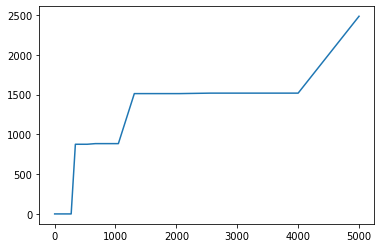

In [ ]:
plt.plot(Size,Errors_train, label = 'Error_train')

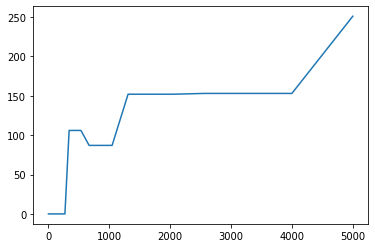

In [ ]:
plt.plot(Size,Errors_test, label = 'Error_test')

1.2

In [8]:
def AvgOptimalSize(tries,std):
  s = []
  for i in range(tries):
    #print('start at trying ',i)
    train2 = data_generator(5000,15,std)
    test2 = data_generator(500,15,std)
    Errors_train = []
    #Errors_test = []
    Size = []
    j = 5000
    while j > 1 :
      DecisionTree = decision_tree(train2,15,j)
      error_train = predict_misclass(train2,DecisionTree)
      error_test = predict_misclass(test2,DecisionTree)
      Size.append(j)
      Errors_train.append(error_train)
      #print('finish tree size =',j,' error = ',error_train, ',',error_test)
      j = math.floor(j/1.25)
    s.append(Size[Errors_train.index(min(Errors_train))])
    print('finish trying ',i,': the optimal size is ',Size[Errors_train.index(min(Errors_train))])

  return np.mean(s)

In [15]:
s = AvgOptimalSize(10,0.05)
print('the average optimal sample size is',s)

finish trying  0 : the optimal size is  218
finish trying  1 : the optimal size is  273
finish trying  2 : the optimal size is  273
finish trying  3 : the optimal size is  273
finish trying  4 : the optimal size is  218
finish trying  5 : the optimal size is  273
finish trying  6 : the optimal size is  273
finish trying  7 : the optimal size is  273
finish trying  8 : the optimal size is  273
finish trying  9 : the optimal size is  273
the average optimal sample size is 262.0


1.3

In [10]:
std = 0.01
Std = []
Errors_train = []
Errors_test = []
while std < 1:
  Std.append(std)
  train3 = data_generator(5000,15,std)
  test3 = data_generator(500,15,std)
  DecisionTree = decision_tree(train3,15,s)
  error_train = predict_misclass(train3,DecisionTree)
  error_test = predict_misclass(test3,DecisionTree)
  Errors_train.append(error_train)
  Errors_test.append(error_test)
  #print('finished std = ', std)
  std += 0.02
  std = round(std, 2)

print(Std)
print(Errors_train)
print(Errors_test)

[0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19, 0.21, 0.23, 0.25, 0.27, 0.29, 0.31, 0.33, 0.35, 0.37, 0.39, 0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.57, 0.59, 0.61, 0.63, 0.65, 0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87, 0.89, 0.91, 0.93, 0.95, 0.97, 0.99]
[0, 0, 0, 0, 2, 4, 127, 5, 23, 18, 41, 61, 53, 84, 108, 120, 126, 143, 176, 193, 192, 221, 235, 270, 290, 326, 333, 377, 364, 399, 417, 430, 436, 502, 528, 528, 567, 538, 588, 630, 605, 656, 625, 595, 685, 687, 767, 757, 714, 768]
[0, 0, 0, 0, 0, 0, 21, 1, 1, 3, 3, 5, 10, 12, 7, 4, 15, 13, 21, 23, 18, 27, 29, 33, 32, 37, 38, 42, 30, 44, 48, 52, 44, 46, 47, 46, 53, 70, 51, 72, 47, 70, 71, 58, 64, 55, 62, 78, 70, 67]


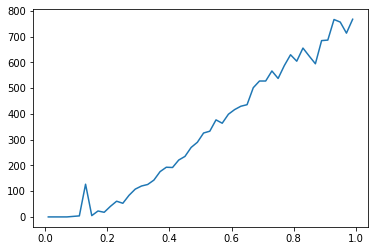

In [11]:
plt.plot(Std,Errors_train, label = 'Error_train')

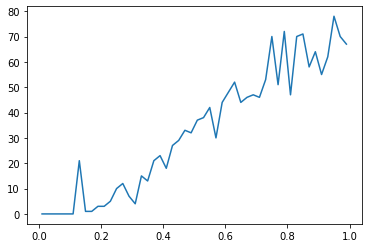

In [12]:
plt.plot(Std,Errors_test, label = 'Error_test')

1.4

In [16]:
def decision_tree_IR(data,d,size):
  if len(data) <= size:
    #print('stop since size')
    value = np.sign(data[:,0].mean())
    if value == 0: 
      value = 1
    temp = Node(None,value)            # Node.y is the return value for terminal nodes
    return temp,0
  count = 0
  variable = getBestIG(data,d)         # the variable with highest IG
  if variable > 5:    # variable > 5 is irrelevent
    count += 1  

  if variable == 0:                    # all IG are zero
    return Node(None,np.sign(data[:,0].mean())),count
  #print('variable=',variable)
  if np.all(data[:,0] == data[:,0][0]):                # y are same 
    #print('stop since y the same')
    return Node(None,data[:,0][0]),count
  if np.all(data[:,variable] == data[:,variable][0]):  # early termination
    #print('stop since early terminate')
    value = np.sign(data[:,0].mean())
    if value == 0: 
      value = 1
    return Node(None,value),count

  Leftdata = data[data[:,variable] == -1]   # Left data are -1
  Rightdata = data[data[:,variable] == 1]   # Right data are +1

  root = Node(variable,0)
  root.left,temp = decision_tree_IR(np.array(Leftdata),d,size)
  count += temp
  root.right,temp = decision_tree_IR(np.array(Rightdata),d,size)
  count += temp
  return root,count

In [ ]:
std = 0.01
Std = []
Errors_train = []
Errors_test = []
IR_count = []
while std <= 3:
  Std.append(std)
  train4 = data_generator(5000,15,std)
  test4 = data_generator(500,15,std)
  DecisionTree,count = decision_tree_IR(train4,15,s)
  IR_count.append(count)
  error_train = predict_misclass(train4,DecisionTree)
  error_test = predict_misclass(test4,DecisionTree)
  Errors_train.append(error_train)
  Errors_test.append(error_test)
  #print('finished std = ', std)
  std += 0.02
  std = round(std, 2)

print(Std)
print(IR_count)
print(Errors_train)
print(Errors_test)

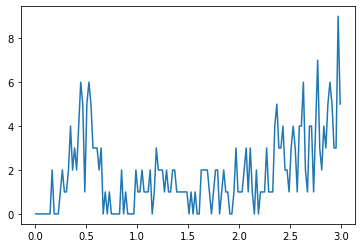

In [33]:
plt.plot(Std,IR_count, label = 'irrelevant feature')